In [1]:
import pandas as pd
import numpy as np

import ipywidgets as widgets
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html
# https://zhuanlan.zhihu.com/p/263411257
# interactive programming package

import matplotlib.pyplot as plt
# https://matplotlib.org/stable/users/explain/interactive.html

%matplotlib inline
# How to use the magic line https://blog.csdn.net/weixin_42311095/article/details/85009922


--Special notes
pandas calculation:
use iloc[row,column] to extract the data.
--Single data point
pd.iloc[row,column].'values'

In [2]:
class Data_Class:
    

    def __init__(self,file_path):
        # set titles, data, current, voltage
        self.titles = ["current/pA","voltage/mV"]
        self.x_label = "t/ ms"
        self.data=[]
        self.current = []
        self.voltage = [] #stored in python list 1xN

        self.max_voltage = []
        
        self.spike_number = 0

        self.threshold = []

        self.spike_train = pd.DataFrame()

        self.spike_features = pd.DataFrame()

        def read_data(data_path):  

            self.data = pd.read_csv(data_path,header=None,sep='\t',index_col=None)
            self.data.columns=[self.titles]
            # print the result
            # print(data.head())
            # backup plan
            # data = np.loadtxt("N1.txt")
            # df = pd.DataFrame(data=data)

            def data_to_list(data):
                '''
                pd Nx1-> list 1xN
                '''
                data.transpose()
                data = data.astype(float)
                return data
            self.file_path = file_path
            self.current = data_to_list(self.data.loc[:,self.titles[0]])
            self.voltage = data_to_list(self.data.loc[:,self.titles[1]])
        read_data(file_path)

    def main(self):
        self.find_other_maximum_points()
        self.voltage_cleaning()
        self.spike_train_extraction()
        print("spike number",self.spike_number)
        self.plot_combined_spike_and_peak()
        self.plot_action_potential()

        def find_features_in_single_spike():
            if self.spike_number == 0:
                self.spike_train_extraction()
            for i in range (self.spike_number):
                S = "S"+str(i+1)
                spike = self.extract_single_spike_data(i)
                S = Spike_Processing(spike,self.file_path,i+1)
                feature_extracted = S.spike_processing_main()
                self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
            return self.spike_features
        find_features = find_features_in_single_spike()
        # Testing new functions
        find_features.to_csv("find_features.csv")

    def plot_data(self):
        # fig, axs = plt.subplots(2, 1, figsize=(4, 3), layout='constrained')
        plt.subplot(211)
        plt.plot(self.current)
        # figure configuration
        # plt.xlabel(x_label)
        plt.ylabel(self.titles[0])

        plt.subplot(212)
        plt.plot(self.voltage)
        # figure configuration
        plt.xlabel(self.x_label)
        plt.ylabel(self.titles[1])
        plt.show()
    def plot_action_potential(self):
        # plot spike train data
        plt.plot(self.spike_train)

    def find_first_max_v(self,start_search=2000,comparison_interval=150):
        '''
        Using the voltage plot to find the first maximum voltage peack

        @ data: should be 1D, and should be voltage
        @ start_search: the index where search is started
        @ comparison_interval: the interval which data[i] is greater than the following data[i+1,i+comparison_interval]
        '''
        first_max = 0
        for i in range(start_search,self.voltage.__len__()):
            flag = False
            while (all(self.voltage[i+1:i+comparison_interval].values<self.voltage.iloc[i,:].values)):
                first_max=self.voltage.iloc[i,:].values
                flag=True
                # print("max index",i)
                self.max_voltage.append([i,float(self.voltage.iloc[i,:].values)])
                break
            if (flag):
                break
        # print("max voltage",first_max)
    def find_other_maximum_points(self,jump=100,end_search=4000):
        '''
        @ jump: to add some value to peak, and continue the spike finding algorithm
        '''
        if self.max_voltage == []:
            self.find_first_max_v()
        if len(self.max_voltage)<=1:
            index = self.max_voltage[0][0]
            spike_count = 1
            while index<end_search:
                self.find_first_max_v(index+jump)
                spike_count += 1
                index = self.max_voltage[spike_count-1][0]
        else:
            pass
    def voltage_cleaning(self,removed_index_range=[3900,6000]):
        remove_index=[]
        for i in range(len(self.max_voltage)):
            if self.max_voltage[i][0]>removed_index_range[0] and self.max_voltage[i][0]<removed_index_range[1]:
                remove_index.append(i)
        remove_index.reverse()
        for j in remove_index:
            self.max_voltage.remove(self.max_voltage[j])
        print("the peaks are: ",self.max_voltage)

        self.spike_number=len(self.max_voltage)
    
    def plot_max_voltage(self):
        def extract_x_y():
            x=[]
            y=[]
            for i in range(len(self.max_voltage)):
                x.append(self.max_voltage[i][0])
                y.append(self.max_voltage[i][1])
            return np.array(x),np.array(y)
        x,y=extract_x_y()
        plt.scatter(x,y,marker="x")
    def spike_extract_from_peak(self,peak_index,lower_bond=100,upper_bond=150):
        spike_train = self.voltage.loc[peak_index-lower_bond:peak_index+upper_bond,:]
        #reset index
        spike_train = spike_train.reset_index(drop=True)
        return spike_train
    def spike_train_extraction(self):
        data = pd.DataFrame()
        for i in range(len(self.max_voltage)):
            peak_index=self.max_voltage[i][0]
            spike=self.spike_extract_from_peak(peak_index)
            data.insert(loc=i, column=str(i), value=spike)
        if self.spike_train.empty:
            self.spike_train = data
        return data
    def plot_combined_spike_and_peak(self):
        if self.max_voltage==[]:
            self.find_other_maximum_points()
            self.voltage_cleaning()
        # fig, axs = plt.subplots(2, 1, figsize=(4, 3), layout='constrained')
        plt.subplot(211)
        plt.plot(self.current)
        # figure configuration
        # plt.xlabel(x_label)
        plt.ylabel(self.titles[0])

        plt.subplot(212)
        plt.plot(self.voltage)
        # figure configuration
        plt.xlabel(self.x_label)
        plt.ylabel(self.titles[1])

        #annotation part of the data
        for i in range(len(self.max_voltage)):
            x,y=self.max_voltage[i][0], self.max_voltage[i][1]
            plt.annotate(str(round(y)),xy=(x,y))
        self.plot_max_voltage()
        plt.show()

    def extract_single_spike_data(self,spike_number):
        if self.spike_train.empty:
            self.spike_train_extraction()
        data = self.spike_train.loc[:,str(spike_number)]
        return data


class Spike_Processing:

    def __init__(self,spike_data,file_name="N1.txt",spike_number=1):
        self.features = pd.DataFrame()
        self.spike_data = spike_data
        self.features["file_name"]=[file_name]
        self.features["spike_number"]=spike_number
    
    def spike_processing_main(self):
        self.find_peak()
        self.find_amplitude
        self.find_min_AHP()
        self.find_threshold()
        self.find_time_to_peak()
        self.find_ISI()
        return self.features
    
    def find_peak(self):
        max = self.spike_data.max()
        maxidx = self.spike_data.idxmax()
        if "max" not in self.features:
            self.features["max"]=[max]
        if "max_idx" not in self.features:
            self.features["max_idx"]=[maxidx]
        return max,maxidx
    
    def find_threshold(self,threshold_rate_of_change=2):
        '''
        @ The spike should be pd series: Nx1
        '''
        def find_the_rate_of_change(index):
            x1=self.spike_data.loc[index]
            x2=self.spike_data.loc[index+1]
            rate_of_change = (x2-x1)/1
            return rate_of_change
        
        for i in range(len(self.spike_data)-1):
            rate = find_the_rate_of_change(i)
            threshold = self.spike_data[i]
            threshold_idx = i
            if rate>threshold_rate_of_change: 
                if "threshold" not in self.features:
                    self.features["threshold"]=[threshold]
                    self.features["threshold_idx"]=[threshold_idx]
                return threshold,threshold_idx
            
    def find_amplitude(self):
        threshold,threshold_idx = self.find_threshold()
        max,maxidx = self.find_peak()
        amplitude = max-threshold
        if "amplitude"  not in self.features:
            self.features["amplitude"]=[amplitude]
        return amplitude

    def find_min_AHP(self):
        max,maxidx = self.find_peak()
        data = self.spike_data[maxidx:]
        min_AHP = data.min()
        min_AHP_idx = data.idxmin()
        if "min_AHP" not in self.features:
            self.features["min_AHP"]=[min_AHP]
        if "min_AHP_idx" not in self.features:
            self.features["min_AHP_idx"]=[min_AHP_idx]
        return min_AHP, min_AHP_idx

    def find_time_to_peak(self):
        # the peak means the bottom point
        max,maxidx = self.find_peak()
        min_AHP,min_AHP_idx = self.find_min_AHP()
        time = min_AHP_idx-maxidx
        if "time_to_peak" not in self.features:
            self.features["time_to_peak"]=[time]
        return time
    
    def find_ISI(self):
        # ISI stands for inter spike interval, which is the time to reach half amplitude
        
        def find_x(x1,y1,x2,y2,y):
            # approximate the value of t, given the x,y coordinate and the wanted x
            x = x1+ (y-y1)*(x2-x1)/(y2-y1)
            return round(x,3)

        amplitude = self.find_amplitude()
        threshold,threshold_idx = self.find_threshold()
        half_amplitude = amplitude/2+threshold
        list = []
        for i in range(len(self.spike_data)-1):
            y1 = self.spike_data[i]
            y2 = self.spike_data[i+1]
            if y1<half_amplitude<y2 or y2<half_amplitude<y1:
                x = find_x(i,y1,i+1,y2,half_amplitude)
                list.append(x)
        ISI = list[1]-list[0]
        if "ISI" not in self.features:
            self.features["ISI"]=[ISI]
        return ISI
            
                       


the peaks are:  [[2246, 34.24292], [2453, 28.16992], [2744, 27.07129], [3061, 27.02551], [3416, 26.56775], [3766, 25.34705]]
spike number 6


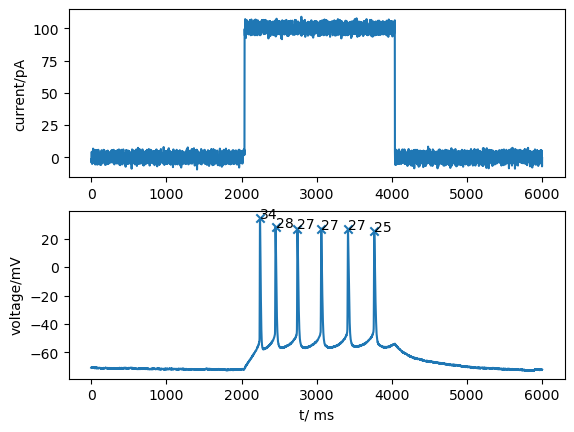

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed 

          0         1         2         3         4         5
0 -62.28418 -56.01282 -54.07495 -54.18176 -53.43408 -52.86951
1 -62.65039 -55.98230 -54.36487 -54.16650 -53.61719 -52.65588
2 -62.48254 -55.81445 -54.13599 -53.89185 -53.60193 -52.59485
3 -62.17737 -55.70764 -54.01392 -53.63245 -53.26624 -52.54907
4 -62.36047 -55.66187 -54.21228 -53.70874 -53.32727 -52.51855


,file_name,spike_number,max,max_idx,min_AHP,min_AHP_idx,threshold,threshold_idx,time_to_peak,amplitude,ISI
0,N2.txt,1,34.24292,100,-57.87439,153,-49.74146,94,53,83.98438,12.050
1,N2.txt,2,28.16992,100,-56.97412,185,-44.85864,93,85,73.02856,13.755
2,N2.txt,3,27.07129,100,-57.01990,204,-44.20251,93,104,71.27380,14.397
3,N2.txt,4,27.02551,100,-56.89783,228,-44.90442,92,128,71.92993,14.987
4,N2.txt,5,26.56775,100,-56.13489,211,-43.88208,92,111,70.44983,15.142
5,N2.txt,6,25.34705,100,-56.66895,248,-43.43958,92,148,68.78663,15.684


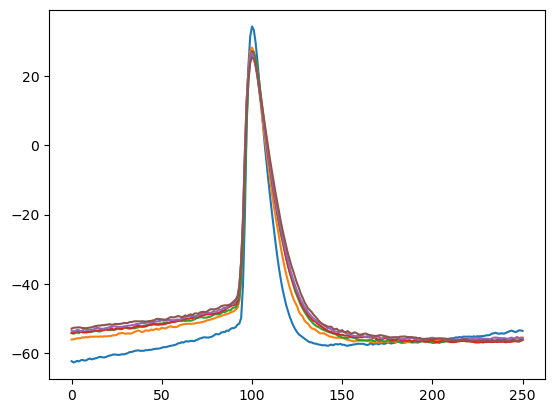

In [5]:
N1 = Data_Class("N2.txt")
N1.main()
print(N1.spike_train.head())
N1.spike_features

the peaks are:  [[2246, 34.24292], [2453, 28.16992], [2744, 27.07129], [3061, 27.02551], [3423, 50.01232], [3766, 25.34705]]
spike number 6


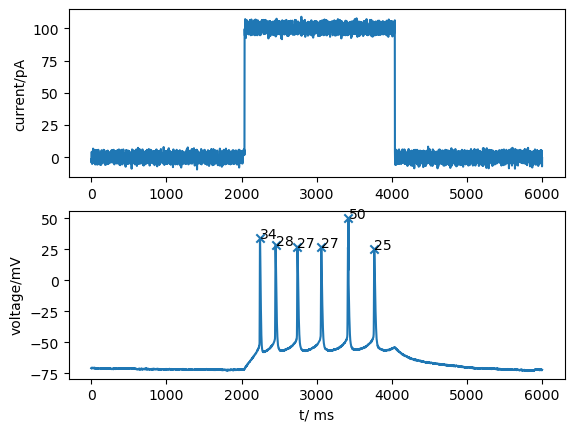

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.spike_features = self.spike_features.append(feature_extracted,ignore_index=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1796\47416924.py:60: FutureWarning: The frame.append method is deprecated and will be removed 

,file_name,spike_number,max,max_idx,min_AHP,min_AHP_idx,threshold,threshold_idx,time_to_peak,amplitude,ISI
0,N1.txt,1,28.16992,100,-56.97412,185,-44.85864,93,85,73.02856,13.755


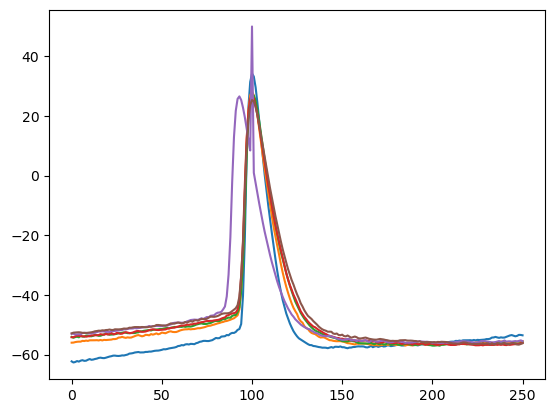

In [7]:
N1 = Data_Class("N1.txt")
N1.main()
spike2 = N1.extract_single_spike_data(1)
S1 = Spike_Processing(spike2)
S1.spike_processing_main()